In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from itertools import product

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))

from model.networks.linear import CalculatedP, LinearP
from general_plots import imshows, plot_vals, simple_imshow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


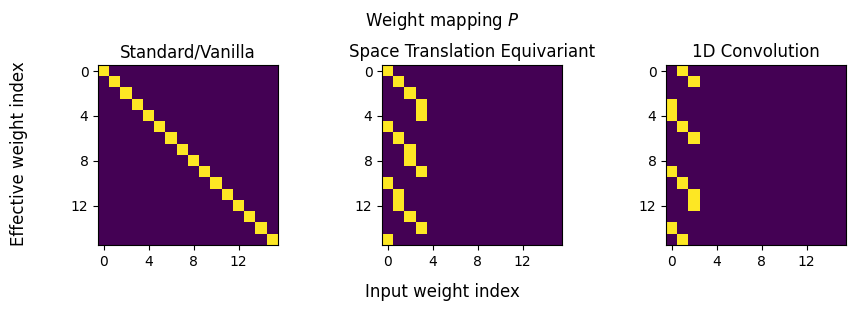

In [47]:
size_plot = 4
transform_funcs = {k: v() for k, v in CalculatedP(size = size_plot).transform_funcs.items()}

Ps = ['none', 'space_translation', 'kernelconv']
title = {
    'none': 'Standard/Vanilla',
    'space_translation': 'Space Translation Equivariant',
    'kernelconv': '1D Convolution'
}

fig, axs = plt.subplots(1, len(Ps), figsize = (len(Ps)*3, 3), tight_layout = True)

for i, P in enumerate(Ps):
    ax = axs[i]
    ax.imshow(transform_funcs[P])
    ax.set_title(title[P])
    ticks = [i * size_plot for i in range(size_plot)]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

fig.suptitle(r'Weight mapping $P$')
fig.supxlabel('Input weight index')
fig.supylabel('Effective weight index')
plt.show()

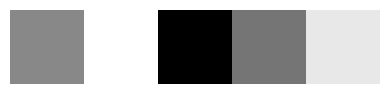

In [26]:
x = torch.randn((1,5))
size = x.shape[-1]
imshows([x], axis_off = True, imshow_kwargs={'cmap': 'gray'}, rows = False)

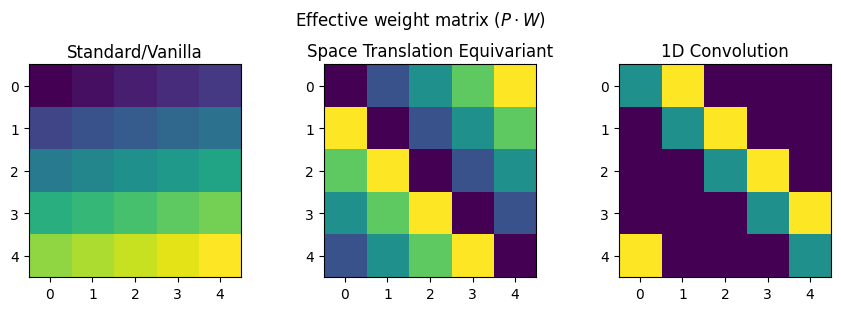

In [50]:
P_inits = ['none', 'space_translation', 'kernelconv']

fig, axs = plt.subplots(1, len(P_inits), figsize = (len(P_inits)*3, 3), tight_layout = True)

for i, P_init in enumerate(P_inits):
    # Initialize linear layer with a specific weight mapping
    linear = LinearP(in_features=size, out_features=size, bias=False, P_init=P_init)

    # Initialize the weight matrix with custom values for easier plotting
    # This line can also be commented. Plot shows the same but less readable
    linear.weight.data = torch.arange(linear.out_features*linear.in_features).reshape(linear.out_features, linear.in_features).float()

    # Apply the weight mapping
    weight = (linear.P @ linear.weight.flatten()).reshape(linear.weight.shape)
    weight = weight.detach().numpy()

    axs[i].imshow(weight)
    axs[i].set_title(title[P_init])

fig.suptitle(r'Effective weight matrix $(P \cdot W)$')
plt.show()

### Checking conv

In [21]:
kernel_size = 3
conv = nn.Conv1d(
    in_channels  = 1, 
    out_channels = 1,
    kernel_size  = kernel_size,
    padding = 1,
    bias = False,
    padding_mode = 'circular',
)
out_conv = conv(x.unsqueeze(0)).squeeze(0)
out_conv


tensor([[-0.1003, -1.1296,  0.8138, -0.8495,  0.5674]],
       grad_fn=<SqueezeBackward1>)

In [24]:
# Initializing the custom linear layer with the mapping P for a convolutional kernel 
linear_conv = LinearP(in_features = size, out_features = size, bias = False, P_init = 'kernelconv')

# Setting the weights of the linear layer to be the same as the convolutional kernel
linear_conv.weight.data.flatten()[:kernel_size] = conv.weight.squeeze()

assert torch.allclose(linear_conv(x, normalize_P=False), out_conv)